In [45]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import json
from sklearn.preprocessing import LabelEncoder

In [46]:
# data_file = "iris.json"
# # Load and prepare data
# data = load_iris()
# X = data.data
# y = data.target
# feature_names = list(data.feature_names)
# target_names = list(data.target_names)

# # PCA setup 
# step = 0.05

In [47]:
data_file = 'fishing.json'
df = pd.read_csv ("test_dataset.csv")
df.dropna(inplace=True)

target_names = [
    "Poor Session", "Below Average", "Average Session", "Above Average", 
    "Good Session", "Great Session", "Excellent Session", 
    "Outstanding", "Legendary", "Epic"
]
feature_names = ['engine_age', 'length', 'power', 'month', 'weight', 'y_month',
       'year', 'surf_temp']

#remove non numerical data 
# value adjusted for inflation (check dataset page for more info)
# other non relevant/not known features 
df.drop(["landing", "patch", "value_cpi", "y_", "ID", "dist", "patch_area", "weight_lym", "weight_lm", "val_lm", "val_lym", "nao_index", "price"], axis=1, inplace=True)

y = df["value"]
X = df[feature_names]

# Split the values into 10 categories with meaningful labels
y = pd.cut(y, bins=10, labels=target_names)

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Convert categories to numerical values

# PCA setup 
step = 0.2 

In [48]:
# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

In [49]:
# Split the data and train the tree (following your original script)
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)
dt_classifier_pca = DecisionTreeClassifier(random_state=42)  # Removed max_depth constraint
dt_classifier_pca.fit(X_train_pca, y_train)

# Generate decision boundary data with finer grid
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

In [50]:
# Get predictions for the grid
Z = dt_classifier_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Get prediction probabilities for more detailed visualization
Z_prob = dt_classifier_pca.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z_prob = Z_prob.reshape((xx.shape[0], xx.shape[1], -1))

C:\Users\alex1\AppData\Local\Temp\ipykernel_9904\1365517753.py:8: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for collection in CS.collections:


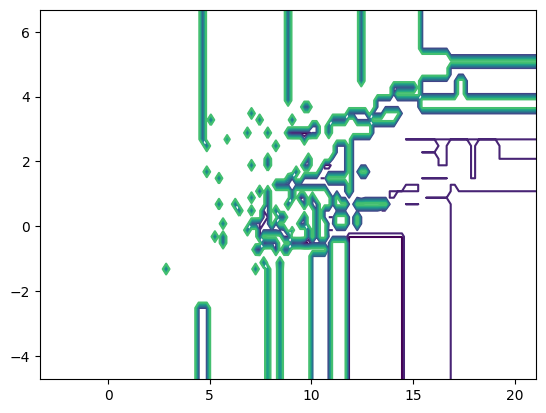

In [51]:
import matplotlib.pyplot as plt

# Suppose you have multiple classes; you can generate contours for each class boundary.
# For example, to get the boundary between two classes, you might set a specific level.
# Adjust the levels based on your specific case.
CS = plt.contour(xx, yy, Z, levels=np.arange(len(target_names) + 1))
boundary_paths = []
for collection in CS.collections:
    for path in collection.get_paths():
        vertices = path.vertices.tolist()  # list of [x, y] coordinates
        boundary_paths.append(vertices)

In [52]:
from sklearn.cluster import KMeans
import numpy as np

def filter_points_by_class_kmeans(points, labels, threshold=500, thresholdMultiplierForClusteringSet=4, random_state=42):
    """
    For each class, if the number of instances exceeds a given threshold,
    cluster the points into k clusters and use the closest real points to the centroids
    as representative points. Otherwise, keep all points.

    Parameters:
        points (np.ndarray): Array of shape (n_points, 2) with PCA coordinates.
        labels (np.ndarray): Array of shape (n_points,) with class labels.
        threshold (int): Minimum number of points a class must have before applying clustering.
        thresholdMultiplierForClusteringSet (int): Multiplier for determining number of sampled points.
        random_state (int): Random seed for reproducibility.

    Returns:
        filtered_points (np.ndarray): Filtered array of representative points.
        filtered_labels (np.ndarray): Corresponding class labels.
    """
    filtered_points = []
    filtered_labels = []
    unique_classes = np.unique(labels)

    for cls in unique_classes:
        # Get indices and points for this class
        class_indices = np.where(labels == cls)[0]
        class_points = points[class_indices]
        n_points = len(class_points)

        if n_points > threshold:
            # Ensure we don't sample more than available
            sample_size = min(threshold * thresholdMultiplierForClusteringSet, n_points)

            rng = np.random.RandomState(random_state)
            sampled_indices = rng.choice(n_points, size=sample_size, replace=False)
            sampled_points = class_points[sampled_indices]

            # Use k-means clustering to find cluster centers
            kmeans = KMeans(n_clusters=threshold, random_state=random_state, n_init=10)
            kmeans.fit(sampled_points)
            centroids = kmeans.cluster_centers_

            # Find the closest real point to each centroid
            selected_points = []
            for centroid in centroids:
                distances = np.linalg.norm(class_points - centroid, axis=1)
                closest_index = np.argmin(distances)
                selected_points.append(class_points[closest_index])

            selected_points = np.array(selected_points)
        else:
            # Keep original points if below threshold
            selected_points = class_points

        filtered_points.append(selected_points)
        filtered_labels.extend([cls] * len(selected_points))

    # Convert to numpy array
    filtered_points = np.vstack(filtered_points)
    filtered_labels = np.array(filtered_labels)

    return filtered_points, filtered_labels

In [53]:
filtered_pca_data, filtered_labels = filter_points_by_class_kmeans(X_pca, y, threshold=2000, thresholdMultiplierForClusteringSet = 5, random_state=42)

print("Original PCA points:", len(X_pca))
print("Filtered PCA points:", len(filtered_pca_data))

Original PCA points: 1473522
Filtered PCA points: 4749


In [54]:
# Function to format all features for axis labels
def format_pc_label(pc_loadings, feature_names, pc_index):
    # Format as string: "PC1: feature1 (+0.62), feature2 (-0.43), ..."
    label = f"PC{pc_index + 1}: " + ", ".join([f"{name} ({value:+.2f})" for name, value in zip(feature_names, pc_loadings)])
    return label

# Generate full labels for PC1 and PC2
pc1_label = format_pc_label(pca.components_[0], feature_names, 0)
pc2_label = format_pc_label(pca.components_[1], feature_names, 1)

In [57]:
with open (data_file, "w") as f:
    json.dump (
        {
            "pcaData": filtered_pca_data.tolist(),
            "targets": filtered_labels.tolist(),
            "targetNames": list(target_names),
            "decisionBoundary": {
                "boundaryPaths": boundary_paths,
                "xRange": [float(x_min), float(x_max)],
                "yRange": [float(y_min), float(y_max)],
                "step": step
            },
            "xAxisLabel": pc1_label,
            "yAxisLabel": pc2_label,
        },
        f,
        indent=4
    )